In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import timeit
import random

# set plot style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [12, 7]

In [2]:
class Turbofan_Deck():
    """
    Calculates engine parameters given:
        Alt : altitude in ft
        MN  : Mach number
        TLA (thrust lever angle) : from 0 to 1.0; 
        simulation time : simulation "clock"
        
    Uses a logistic curve to simulates engine response.
    from idle to full power in 8 seconds (civil certification requirement)

    The engine response is defined by :
    f(x) = L / (1 + exp(-k(x-x0))
    where:
        x is the input
        L is the max value 
        k is the growth rate
        x0 is the midpoint

    TLA is mapped to actual engine PC (power percent),
    which is used to interpolate data from the deck LUT

    returns engine data in a dictionary
    """

    def __init__(self, input_file:str, initial_TLA:float=0.0, initial_time:float=0.0):
        """
        Initializes the thrust logistic function response shaping and 
        deck parameters (dataframe)

        Args:
            input_file (str): the name of the deck file to be read (csv)
            initial_TLA (float, optional): The initial thrust lever angle (TLA) at initial_time.
                                             Defaults to 0.0.
            initial_time (float, optional): The starting time of the simulation. Defaults to 0.0.
        """

        # define logistic function parameters
        self.window_start_TLA = 0.0 # initial TLA value when change is triggered
        self.window_target_TLA = 1.0 
        self.window_start_time = 0.0 # time when TLA change was triggered
        self.current_TLA = 0.0 # TLA value as we ramp through function
        self.L = 1.0 # logistic function "carrying capacity", akin to gain
        self.t0_long = 4.5 # logistic function midpoint, for large TLA changes
        self.k_long = 1.1 # logistic function growth rate, for large TLA changes
        self.t0_short = 1.5 # midpoint for small TLA changes
        self.k_short = 2.1 # growth rate for small TLA changes
        self.dTLA_long = 0.4 #threshold for large TLA changes
        self.dTLA_short = 0.15 #threshold for small TLA changes
        self.k_slope = (self.k_long - self.k_short) / (self.dTLA_long - self.dTLA_short)
        self.k_intcpt = self.k_short - self.k_slope * self.dTLA_short
        self.t0_slope = (self.t0_long - self.t0_short) / (self.dTLA_long - self.dTLA_short)
        self.t0_intcpt = self.t0_short - self.t0_slope * self.dTLA_short
        self.current_k = self.k_long
        self.current_t0 = self.t0_long


        # read deck file
        self.input_file = input_file #csv file name to be read with deck data
        try:
            self.deck_df = pd.read_csv(input_file, header=0)
            # if 19000ft bug is included in the csv file, uncomment line below
            #self.deck_df = self.deck_df[(self.deck_df.alt<18500) | (self.deck_df.alt>19999)]
        except FileNotFoundError:
            print(f"Error: The file '{input_file}' was not found.")
        except pd.errors.EmptyDataError:
            print(f"Error: The file '{input_file}' is empty.")
        except pd.errors.ParserError:
            print(f"Error: The file '{input_file}' could not be parsed.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")


        # extract key values from deck
        # make a list of altitudes and Mach numbers we have in the deck data
    
        # first create a list of the unique altitudes
        self.alts = self.deck_df['alt'].unique()
    
        # then, for each altitude, create a list of MNs... let's create a dictionary
        self.alt_MN = {}
        for alt in self.alts:
            self.alt_MN[alt] = self.deck_df[self.deck_df['alt'] == alt]['MN'].unique().tolist()
    
        # likewise, a list of PCs
        # here we check at the first altitude and Mach=0 only. Sufficient.
        self.PCs = self.deck_df[(self.deck_df['alt'] == self.deck_df['alt'][0]) & 
                  (self.deck_df['MN'] == self.deck_df['MN'][0])]['PC'].unique().tolist()
    
        # capture the column names in a list to make our life easier
        self.col_names = self.deck_df.columns.to_list()
        

    def _dynamic_response(self, TLA_demand:float)->float:
        '''
        changes the logistic function parameters according to the delta TLA
        for big changes, parameters are set for slow, 8s response
        for small TLA changes, parameters are set for fast response
        interpolates in between
        '''
        dTLA = abs(TLA_demand - self.window_target_TLA)
        if dTLA > self.dTLA_long:
            return self.k_long, self.t0_long
            
        elif dTLA < self.dTLA_short:
            return self.k_short, self.t0_short
            
        else:
            k = dTLA * self.k_slope + self.k_intcpt
            t0 = dTLA * self.t0_slope + self.t0_intcpt
            return k, t0

        
    def _TLA_response(self, t:float, TLA_demand:float)->float:
        '''
        uses logistic function to shape TLA input into a simulated engine response
        we set the start of the sliding window every time TLA changes
        inputs
            t: the current simulation time
            TLA_demand: the thrust lever angle "at the cockpit"
        returns
            shaped TLA that will be used to get deck response
        '''
        if TLA_demand == self.window_target_TLA:
            #no change in target, calculate response with same parameters
            dt = t - self.window_start_time
            if dt < 10 and dt > 0: # logistic function window
                self.current_TLA = (((self.L) / 
                                   (1 + np.exp(-self.current_k * (dt - self.current_t0))) *
                                     (self.window_target_TLA - self.window_start_TLA)) +
                                   self.window_start_TLA)
            elif dt > 0:
                self.current_TLA = self.window_target_TLA
                self.window_start_TLA = self.window_target_TLA
                
            return self.current_TLA
            
        else:
            #we have a new target
            # set window start time, parameters and target
            self.window_start_time = t
            self.window_start_TLA = self.current_TLA
            self.current_k, self.current_t0 = self._dynamic_response(TLA_demand)
            self.window_target_TLA = TLA_demand

            return self.current_TLA
        

    def _get_PC_from_TLA(self, TLA:float, idle:float)->float:
        """
        TLA ranges from 0 = idle
                to      1 = TOGA
        this needs to be mapped to:
                        PC = idle
                        PC = 1.0 = TOGA
        note that idle is a variable because the engine idle varies with altitude.
        idle = 0.55 at sea level, increases with altitude
        """
        
        return TLA * (1.0 - idle) + idle
        

    def _get_idle(self, altitude:float)->float:
        """
        given an altitude, returns idle value
        """
        # simple table
        if altitude < 3000:    return 0.55
        elif altitude < 5000:  return 0.58
        elif altitude < 8000:  return 0.60
        elif altitude < 25000: return 0.65
        elif altitude < 32000: return 0.67
        else:                  return 0.7
            

    def _get_bracket(self, target:float, val_list:list)->float:
        '''
        given a target value, find neighbouring lower and higher
        values from a list. Ex: target = 5, list = [1,2,3,4,5,6,7]
        returns low_val=4, high_val=6
        note: the val_list maybe unordered.
        inputs:
            target: value
            val_list: list of values (maybe out-of-order)
        outputs:
            lower value, higher value
        '''
        
        highs = []
        lows = []
        
        for x in val_list:
            if x >= target:
                highs.append(x)
            else:
                lows.append(x)
        
        if highs: # if this list is not empty, we get the min
            high_val = min(highs)
        else: #otherwise it means we are on the edge.
            high_val = max(val_list)
        
        if lows: # same idea
            low_val = max(lows)
        else:
            low_val = min(val_list)
        
        return low_val, high_val
        

    def _linear_interp(self, x:float, x3:float, x1:float, y2:float, y1:float)->float:
        '''
        simplest form of linear interpolation between 2 data points
        inputs.
            x: value to be interpolated at
            x3, X1: x-coordinates of first and second data points
            y1, y2: y-coordinates of first and second data points
        returns
            interpolated value
        '''
        
        m = (y2 - y1) / (x3 - x1)
        x0 = y1 - m * x1
        
        return m * x + x0
        

    def _adjust_limits(self, val:float, val_list:list)->float:
        '''
        This function is used to adjust the interpolation limits for edge cases
        Given a value and a list (ordered)
        If value out-of-range, get 2 closest values
        '''
        
        if abs(val - val_list[0]) > abs(val - val_list[-1]): # we are at the high end
            # get 2 highest values
            high_val = val_list[-1]
            low_val = val_list[-2]
        else: # we are at the low end, get 2 lowest values
            high_val = val_list[1]
            low_val = val_list[0]
            
        return low_val, high_val
        

    def _interp_altMNPC(self, Hp:float, MN:float, PC:float)->dict:
        '''
        This function will return a tri-linearly interpolated
        dictionary for each "key" in the self.deck_df class dataframe set in __init__.
        
        inputs
            Hp: altitude (in ft)
            MN: Mach number
            PC: power setting (float between 1 and 0)
        retunrs
            res: dictionary with interpolated values for each key in the dataframe
        '''
        
        ###############################
        #   DEFINE THE BRACKETS        #
        ###############################
        # the idea here is to find the data to interpolate from
        # it is all in the database, we just need to filter it.
        # we will find the altitude bracket
        # then the Mach bracket
        # and finally the PC bracket
    
        # this dictionary will hold the altitude and Mach barckets
        pt_bracket = {'low': {'alt':0, 'M_low':0, 'M_high':0}, 'high': {'alt':0, 'M_low':0, 'M_high':0}}  # initialize to zero
        
        pt_bracket['low']['alt'], pt_bracket['high']['alt'] = self._get_bracket(Hp, self.alt_MN.keys()) # populate altitudes
        if pt_bracket['low']['alt'] == pt_bracket['high']['alt']: # check if we are out-of-range
            # adjust the low and high values to the 2 nearest points
            pt_bracket['low']['alt'], pt_bracket['high']['alt'] = self._adjust_limits(Hp, sorted(list(self.alt_MN.keys())))
    
        # now, Mach
        # we will have 'low altitude' x 'M_low'
        #              'low altitude' x 'M_high'
        #              'high altitude' x 'M_low'
        #              'high altitude' x 'M_high'
        for lh in ['low', 'high']:
            pt_bracket[lh]['M_low'], pt_bracket[lh]['M_high'] = self._get_bracket(MN, self.alt_MN[pt_bracket[lh]['alt']]) # populate MNs for each alt
    
            if pt_bracket[lh]['M_low'] == pt_bracket[lh]['M_high']: # check if we are out-of-range
            # dump keys into list
                MN_list = [M for M in self.alt_MN[pt_bracket[lh]['alt']]]
                pt_bracket[lh]['M_low'], pt_bracket[lh]['M_high'] = self._adjust_limits(MN, sorted(MN_list))
    
        # finally, the PCs
        PC_low, PC_high = self._get_bracket(PC, self.PCs)
        if PC_low == PC_high: # check if we are out-of-range
            PC_low, PC_high = self._adjust_limits(PC, sorted(self.PCs))
    
    
        ###############################
        #   INTERPOLATE               #
        ###############################
        
        interp_pts = [] # temporary placeholder for interpolation points converted to numpy from dataframe

        # now we dump our data to numpy arrays to facilitate the interpolation math
        if pt_bracket['low']['alt'] != pt_bracket['high']['alt']:
            interp_pts.append(self.deck_df.query(f"alt == {pt_bracket['high']['alt']} and (MN == {pt_bracket['high']['M_high']})").to_numpy())
            interp_pts.append(self.deck_df.query(f"alt == {pt_bracket['high']['alt']} and (MN == {pt_bracket['high']['M_low']})").to_numpy())
            interp_pts.append(self.deck_df.query(f"alt == {pt_bracket['low']['alt']} and (MN == {pt_bracket['low']['M_high']})").to_numpy())
            interp_pts.append(self.deck_df.query(f"alt == {pt_bracket['low']['alt']} and (MN == {pt_bracket['low']['M_low']})").to_numpy())
        else:
            print('error finding brackets!')
        
        #interpolation - tri linear
        temp_pts = [] # temporary placeholder for intermmedeate interpolation points
    
        # first, interpolate PCs
        x3 = PC_high
        x1 = PC_low
        for i in range(4):
            y2 = interp_pts[i][np.where(interp_pts[i][:,self.col_names.index('PC')] == x3)]
            y1 = interp_pts[i][np.where(interp_pts[i][:,self.col_names.index('PC')] == x1)]
            temp_pts.append(self._linear_interp(PC, x3, x1, y2, y1))
    
        # second, interpolate Mach number
        temp_pts2 = [] #temp placeholder
    
        for idx, i in enumerate(['high', 'low']):
            x3 = pt_bracket[i]['M_high']
            x1= pt_bracket[i]['M_low']
            y2 = temp_pts[(2*idx)] #0, 2
            y1 = temp_pts[(2*idx)+1] #1, 3
            temp_pts2.append(self._linear_interp(MN, x3, x1, y2, y1))
    
        # third, interpolate altitudes (hence, tri-linear interp)
        x3 = pt_bracket['high']['alt']
        x1= pt_bracket['low']['alt']
        y2 = temp_pts2[0]
        y1 = temp_pts2[1]
        interp_data = self._linear_interp(Hp, x3, x1, y2, y1)
    
        # now, we package our output in a dictionary:
        res = {}
        for idx, col in enumerate(self.col_names):
            res[col] = interp_data[0][idx]
            
        return res

    def run_deck(self, alt:float, MN:float, TLA:float, current_time:float)->dict:
        """
        mainclass API to run deck
        inputs:
            alt: altitude in ft
            MN:  Mach number
            TLA: thrust lever angle
            current_time: time to run the simulation at
                this is in relation to the initial time when the class object was instantiated
                (see __init__)
        returns:
            interpolated deck data for current simulation time
            fakes TLA to get a ramped engine response to 
            throttle changes
        """

        idle_PC = self._get_idle(alt)
        TLA_temp = self._TLA_response(current_time, TLA)
        PC = self._get_PC_from_TLA(TLA_temp, idle_PC)
        
        return self._interp_altMNPC(alt, MN, PC)

In [3]:
# instantiate the deck
initial_time = time.perf_counter()
CF34_10_E5A1 = Turbofan_Deck("CF34_deck_v3.csv", initial_TLA=0.0, initial_time=initial_time)


In [4]:
# test run, with throttle changes
alt = 35000
MN = 0.82
TLA = 0.00
x1 = [] # throttle values
x2 = [] # PC
x3 = [] # thrust (from deck)

time_vect = []
for i in range(1000):
    engine_state = CF34_10_E5A1.run_deck(alt, MN, TLA, time.perf_counter())
    x1.append(TLA)
    x3.append(engine_state['Fn'])
    x2.append(engine_state['PC'])
    time_vect.append(time.perf_counter() - initial_time)
    if i%100 == 0:
        print()
        print(i)
    print('-', end='')

    # some throttle variations
    if i > 100:  TLA = 0.5
    if i > 200:  TLA = 0.85
    if i > 400:  TLA = 1.0
    if i > 430:  TLA = 0
    if i > 550:  TLA = 0.9
    
    # realistic, variable time delay
    # note, it seems to run slow because we are actually using
    # the system timer and asking the CPU to sleep
    tdlay = 0.1+(random.randint(1,9)/100)
    time.sleep(tdlay)
print('EOL')


0
--------------------------------------------------------------------------------------------------
100
--------------------------------------------------------------------------------------------------
200
---------------------------------------------------------------------------------------------------
300
--------------------------------------------------------------------------------------------------
400
--------------------------------------------------------------------------------------------------
500
--------------------------------------------------------------------------------------------------
600
--------------------------------------------------------------------------------------------------
700
---------------------------------------------------------------------------------------------------
800
--------------------------------------------------------------------------------------------------
900
--------------------------------------------------------------------

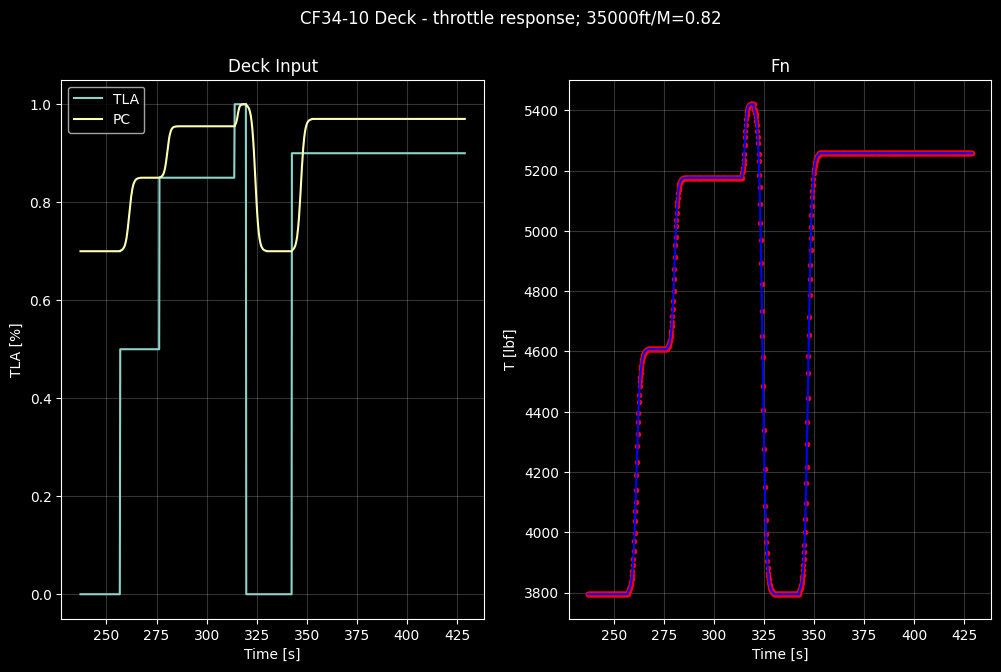

In [5]:
# quick plot
fig, (ax1, ax3) = plt.subplots(1, 2)
fig.suptitle(f'CF34-10 Deck - throttle response; {alt}ft/M={MN}')

ax1.plot(time_vect, x1, label='TLA')
ax1.plot(time_vect, x2, label='PC')
ax3.plot(time_vect, x3, '.', color='red')
ax3.plot(time_vect, x3, '-', color='blue')


ax1.set_title('Deck Input')
ax1.set(xlabel='Time [s]', ylabel='TLA [%]')
ax1.grid(alpha=0.2)
ax1.legend()

ax3.set_title('Fn')
ax3.set(xlabel='Time [s]', ylabel='T [lbf]')
ax3.grid(alpha=0.2)

fig.show()

In [6]:
# API timing check
niter = 1000 # number of runs to average our timing
MN = 0.8
alt = 35000
TLA = 0.9
print(f'MN={MN}, alt={alt}, TLA={TLA}')
API_total_time = timeit.timeit(lambda: CF34_10_E5A1.run_deck(alt, MN, TLA, time.perf_counter())['Fn'], number=niter)
print(f'{niter} calls: {API_total_time:.3f} seconds, equates to {1/(API_total_time/niter):.1f}Hz')

MN=0.8, alt=35000, TLA=0.9
1000 calls: 32.036 seconds, equates to 31.2Hz
